In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import label_binarize

/usr/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
dataset = datasets.ImageFolder(root='/home/luizp/projects/pibit/cicIds/gen', transform=transform)
dataset_size = len(dataset)

In [4]:
train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

In [5]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
#train_data = datasets.ImageFolder(root='/home/luizp/projects/pibit/cicIds/gen', transform=transform)
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),            
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),            
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
        
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),            
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),            
      nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [10]:
alexnet = AlexNet()
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
num_epochs = 2
mhistory = []
all_labels = []
all_preds = []
for epoch in range(num_epochs):
  a = 0
  mhistory.append([])
  all_labels.append([])
  all_preds.append([])
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    mhistory[epoch].append(loss.item())
    all_labels[epoch].extend(labels.cpu().numpy())
    all_preds[epoch].extend(torch.argmax(outputs, 1).cpu().numpy())
    clear_output(wait=True)
    print(f'{a}/{len(train_loader)} Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}', end=",")
    a = a + 1

    

1411/1412 Epoch 2/2, Loss: 0.6817826628684998,

In [7]:
checkpoint_path = '/home/luizp/alexnet_model.pth'

# Salva o estado do modelo, incluindo parâmetros e otimizador
torch.save({
    'epoch': num_epochs,
    'model_state_dict': alexnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, checkpoint_path)

print(f'Modelo salvo em {checkpoint_path}')

Modelo salvo em /home/luizp/alexnet_model.pth


In [33]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
print(all_labels.shape, all_preds.shape)

(2, 180716) (2, 180716)


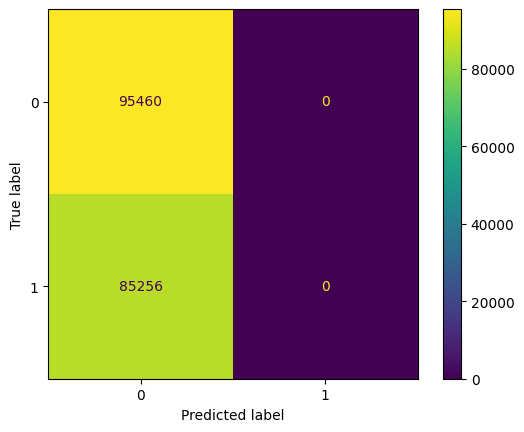

In [35]:
conf_matrix = confusion_matrix(all_labels[0], all_preds[0])
ConfusionMatrixDisplay(conf_matrix).plot()

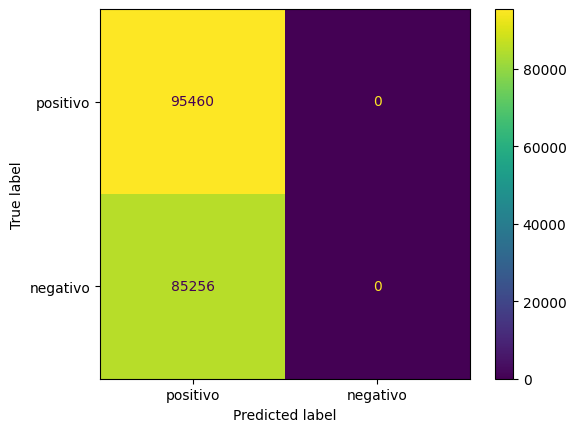

In [41]:
conf_matrix = confusion_matrix(all_labels[1], all_preds[1])
ConfusionMatrixDisplay(conf_matrix, display_labels=['positivo', 'negativo']).plot()

In [42]:
conf_matrix

array([[95460,     0],
       [85256,     0]])

In [17]:
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:  # Supondo que você tenha um conjunto de teste (test_loader)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probabilidade da classe positiva

In [23]:
fpr, tpr, thresholds = roc_curve(all_labels[:112], probs)
roc_auc = auc(fpr, tpr)

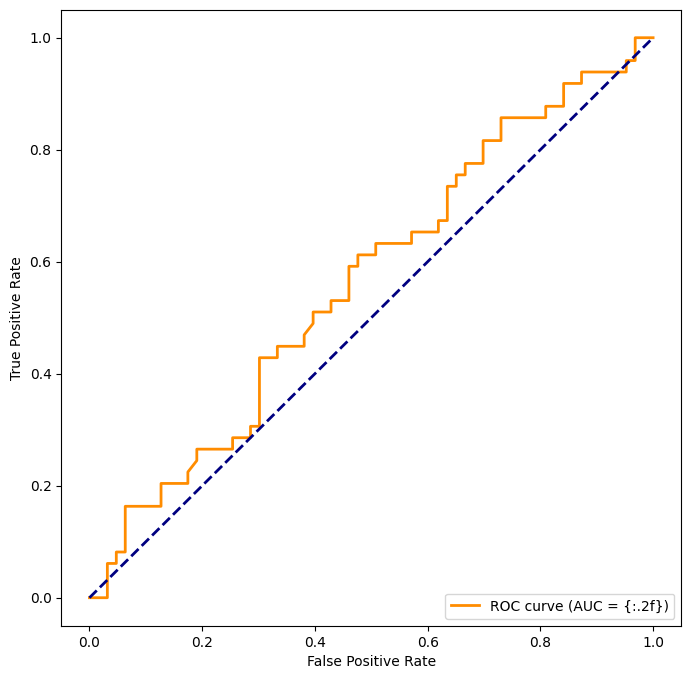

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [37]:
fpr, tpr, thresholds = roc_curve(all_labels[0][:112], probs)
roc_auc = auc(fpr, tpr)

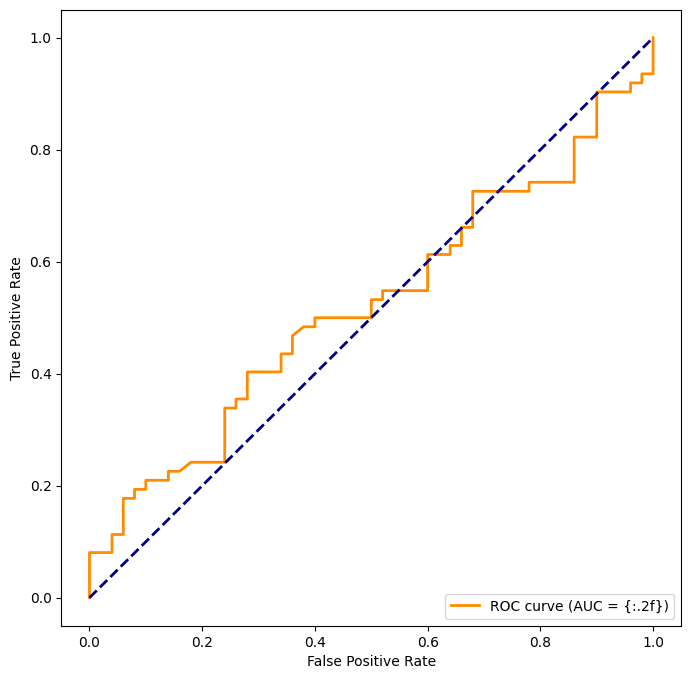

In [38]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [39]:
fpr, tpr, thresholds = roc_curve(all_labels[1][:112], probs)
roc_auc = auc(fpr, tpr)

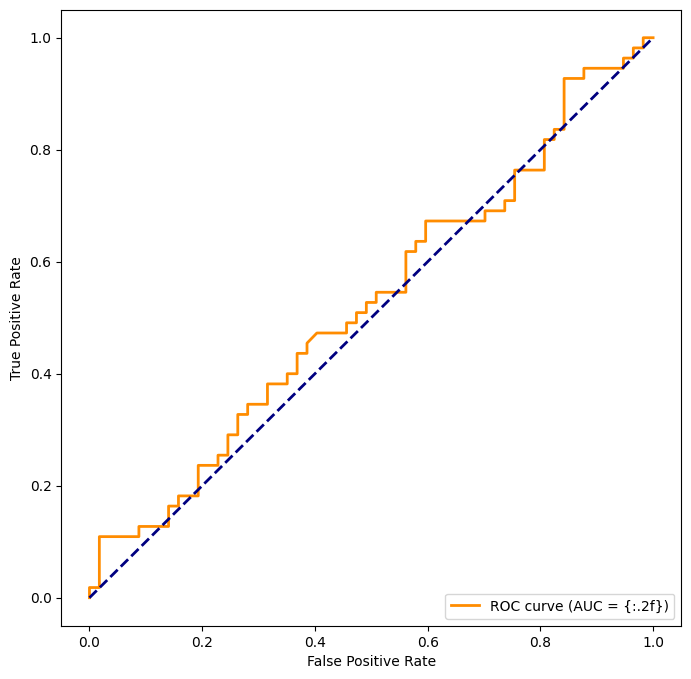

In [40]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()